# Trajectory Clustering with Cuspatial and scikit-learn

### The task is grouping a set of trajectories in such a way that trajectories in the same group are more similar to each other than to those in other groups.

### It consists of two major components:

1. Similarity Metric
2. Searching Algorithm

### Here we do the clustering task in two separate steps:

1. Calculate the similarity between all trajectory pairs.
2. Apply searching algorithm on the pre-computed similarity matrix. Here we tried two algorithms: AgglomerativeClustering (AC) and DBSCAN.

### The reason to split the cluster task into the two separate steps: 

* Once a similarity metric is chosen, still need to try different hyperparameter combinations of the searching algorithm to get a good clustering result. 

* Calculating the similarity is usually the more computationally intense task and we don't want to re-compute it at each hyperparameter search iteration.

## How Cuspatial helps:

* Cuspatial can significantly accelerate the trajectory similarity metric computation. 

* Currently cuspatial have implemented `Hausdorff distance` between trajectory pairs.

* we are going to use `Hausdorff distance` as the similarity metric in the following experiments.

## How cuML helps:

* cuML accelerates computing AC and DBSCAN on GPU


In [2]:
import os
import random
import time
import pickle

import cv2
import numpy as np
import cupy as cp
from ipywidgets import interact
from ipywidgets import *
import matplotlib.pyplot as plt
from matplotlib import gridspec
from skimage import io, transform

import cuspatial
import cuml

# LOCUST DATA

### load preprocessed trajectories

In [3]:
!if [ ! -f "trajectories_extracted.p" ]; then wget -O trajectories_extracted.p "https://drive.google.com/uc?export=download&id=1GE-_z9HgLp3eV7Lgo_KOl53QuMgiCUMS"; else echo "trajectories_extracted.p found"; fi

trajectories_extracted.p found


In [4]:
with open('trajectories_extracted.p','rb') as f:
    trajectories = pickle.load(f)

### define trajectory transform functions

In [5]:
def convert_latlon_2_image_for_vis_wrongway_intersection(lat,long):

    x_anchor = 436.369
    y_anchor = 126.613
    long_anchor = -90.666714
    lat_anchor = 42.492466

    long_1 = -90.663183
    lat_1 = 42.491671
    x_1 = 971.026
    y_1 = 291.955

    long_2_x_rate = (x_1-x_anchor)/(long_1-long_anchor)
    lat_2_y_rate = (y_1-y_anchor)/(lat_1-lat_anchor)

    y = (lat-lat_anchor)*lat_2_y_rate+y_anchor
    x = (long-long_anchor)*long_2_x_rate+x_anchor

    return x, y

def convert_traj_latlon_2_image_wrongway_intersection(traj):
    """Transform trajectory coordinates to image coordinate."""
    traj_image = [
        convert_latlon_2_image_for_vis_wrongway_intersection(
            lat,long
        ) for lat, long in traj
    ]

    return np.asarray(traj_image)

def traj_filter_num_points(trajectories, num_min):
    """Filter short trajectories"""
    max_length = 0
    min_length = 999
    
    long_trajectories = [traj for traj in trajectories if len(traj) >= num_min]
    lengths = [len(traj) for traj in long_trajectories]
    max_length = max(len(traj) for traj in trajectories)
    min_length = min(lengths)
    
    print("the longest traj length is: ",max_length)
    print("the shortest traj length is: ",min_length)
    print("the average traj length is: ",int(np.mean(lengths)))
    return long_trajectories

def pick_traj_with_label(pick, labels, trajectories):
    """Filter trajectory by labels"""
    selected_trajectories = [
        traj for traj_label, traj in zip(labels, trajectories) if traj_label == pick
    ]
    return selected_trajectories

### filter and transform trajectories

In [6]:
print('Filtering based on number of points ...')
trajectories = traj_filter_num_points(trajectories,num_min=30)
print(f'{len(trajectories)} left after filtering based on number of points')

trajectories = [convert_traj_latlon_2_image_wrongway_intersection(trajectory) for trajectory in trajectories]

Filtering based on number of points ...
the longest traj length is:  961
the shortest traj length is:  30
the average traj length is:  87
10070 left after filtering based on number of points


### Visualize the filtered trajectories

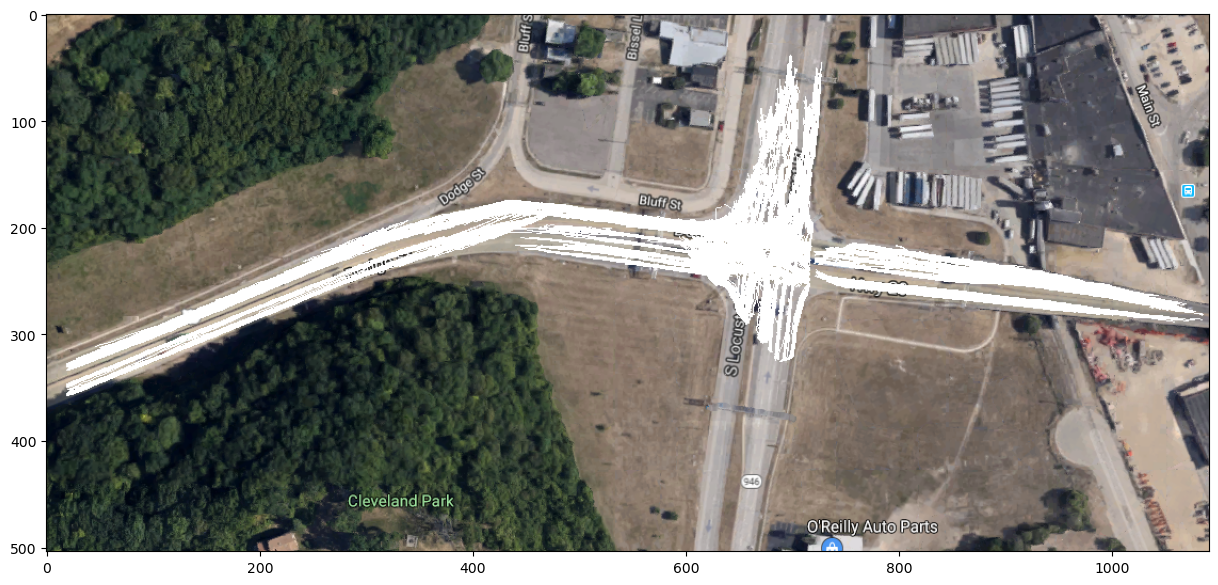

In [7]:
MAP_FILE = 'target_intersection.png'
bg_image = io.imread(MAP_FILE)
scale = (42.489814152793585,-90.67464958318888,42.492905837844546,-90.66237875113197)
img = np.copy(bg_image)
for trajectory in trajectories:
    cv2.polylines(img,np.int32([np.array(trajectory).reshape(-1,1,2)]),False, (255,255,255), 1)

plt.figure(figsize=(15,15))
plt.imshow(img)

## Clustering Step1: 

### Calculate `Hausdroff distance` matrix using scipy library (multithreaded)

### It took 38454.909 seconds (~10.7 hours) to finish. (Uncomment to run)

In [10]:
# import math
# from scipy.spatial.distance import directed_hausdorff
# from itertools import combinations_with_replacement
# from joblib import Parallel, delayed

# def hausforff_distance(u,v):
#     return max(directed_hausdorff(u, v)[0], directed_hausdorff(v, u)[0])

# def timeSince(since):
#     now = time.time()
#     s = now - since
#     m = math.floor(s / 60)
#     s -= m * 60
#     return '%dm %ds' % (m, s)

# start = time.time()
# dmatrix=np.zeros((len(trajectories),len(trajectories)))
# count = 0
# total = len(trajectories)*len(trajectories)

# def compute_single(dmatrix, i, j):
#     return hausforff_distance(trajectories[i],trajectories[j])

# # out = Parallel(n_jobs=78, verbose=3)(delayed(compute_single)(dmatrix, i, j) for i in range(dmatrix.shape[0]) for j in range(dmatrix.shape[1]))
# out = Parallel(n_jobs=10, verbose=3)(delayed(compute_single)(dmatrix, i, j) for i, j in combinations_with_replacement(range(len(trajectories)), 2))
# dmatrix = np.asarray(out).reshape((len(trajectories), len(trajectories)))

# end = time.time()
# print('duration:',end-start)

### Calculate `Hausdroff distance` matrix using cuspatial library (GPU)

#### keep an eye on the speed.

In [8]:
start = time.time()

# Prepare data for GPU
# Concatenating all trajectories
trajs = cp.concatenate([cp.asarray(traj) for traj in trajectories], axis=0).flatten()

# `offset` denote the starting index for each trajectory
offsets = cp.asarray([0] + [len(traj) for traj in trajectories]).cumsum()[:-1]

traj_spaces = cuspatial.GeoSeries.from_multipoints_xy(trajs.astype('f8'), offsets.astype('i4'))
print(traj_spaces.head())

start1 = time.time()
dist=cuspatial.directed_hausdorff_distance(traj_spaces)
end1 = time.time() 
print('\nHausdroff distance calculation by Cuspatial in GPU takes: \n  {0:.3f} seconds (4800X)'.format(end1 - start1))
dmatrix=dist.to_cupy().T.get()
end = time.time()
print('\nThe complete Dmatrix calculation including data transitioning and transforming takes: \n  {0:.3f} seconds (3300X)'.format(end - start))

0    MULTIPOINT (95.387 326.899, 97.281 326.106, 10...
1    MULTIPOINT (99.380 296.802, 100.572 296.408, 9...
2    MULTIPOINT (674.339 272.198, 674.399 272.657, ...
3    MULTIPOINT (587.832 240.090, 588.061 240.461, ...
4    MULTIPOINT (823.491 240.381, 822.564 240.276, ...
dtype: geometry

Hausdroff distance calculation by Cuspatial in GPU takes: 
  3.338 seconds (4800X)

The complete Dmatrix calculation including data transitioning and transforming takes: 
  9.067 seconds (3300X)


In [11]:
start = time.time()
agg = cuml.AgglomerativeClustering(n_clusters=10, linkage = 'single')
agg_result = agg.fit(dmatrix)
end = time.time()
print('A complete AC search takes:\n  {0:.3f} seconds'.format(end - start))

A complete AC search takes:
  3.012 seconds


In [13]:
start = time.time()
dbscan = cuml.DBSCAN(eps=20, metric='precomputed',min_samples=2)
dbscan_result = dbscan.fit(dmatrix)
end = time.time()
print('A complete DBSCAN search takes:\n  {0:.3f} seconds'.format(end - start)) 

A complete DBSCAN search takes:
  0.839 seconds


### Visualize AgglomerativeClustering results (all clusters overlaid, interactive mode)

In [12]:
def visualize_gt_vs_pred(n_clusters,linkage):
    print('AgglomerativeClustering')
    agg = AgglomerativeClustering(n_clusters=n_clusters, metric='precomputed', linkage = linkage)
    agg_result = agg.fit(dmatrix)
    
    labels = agg_result.labels_

    print('#clusters = ',np.max(labels)+1)
    img = np.copy(bg_image)
    for label in range(np.max(labels)+1):

        color = (random.randint(0,255),random.randint(0,255),random.randint(0,255))
        selected_trajectories = pick_traj_with_label(label,labels,trajectories)


        for trajectory in selected_trajectories:
            cv2.polylines(img,np.int32([np.array(trajectory).reshape(-1,1,2)]),False, color, 2)
    plt.figure(figsize=(15,15))
    plt.imshow(img)
    
    
    
interact(visualize_gt_vs_pred,
         n_clusters=widgets.IntText(value=12,description='n_clusters:',disabled=False),
         
         linkage=widgets.ToggleButtons(
                value='average',
                options=['complete', 'average', 'single'],
                description='linkage:',
                disabled=False,
                button_style='', # 'success', 'info', 'warning', 'danger' or ''
            )
        )

interactive(children=(IntText(value=12, description='n_clusters:'), ToggleButtons(description='linkage:', inde…

<function __main__.visualize_gt_vs_pred(n_clusters, linkage)>

### Visualize DBSCAN results (all clusters overlaid, interactive mode)

In [14]:
def visualize_gt_vs_pred(eps,min_samples):
    print('DBSCAN')
    dbscan = DBSCAN(eps=eps, metric='precomputed',min_samples=min_samples)
    dbscan_result = dbscan.fit(dmatrix)
    
    labels = dbscan.labels_

    print('#clusters = ',np.max(labels)+1)
    img = np.copy(bg_image)
    for label in range(np.max(labels)+1):

        color = (random.randint(0,255),random.randint(0,255),random.randint(0,255))
        selected_trajectories = pick_traj_with_label(label,labels,trajectories)


        for trajectory in selected_trajectories:
            cv2.polylines(img,np.int32([np.array(trajectory).reshape(-1,1,2)]),False, color, 2)
    plt.figure(figsize=(15,15))
    plt.imshow(img)
    
interact(visualize_gt_vs_pred,
         min_samples=widgets.IntText(value=600,description='min_samples:',disabled=False),
         
         eps=widgets.ToggleButtons(
                value=20,
                options=[5,10,11,12,13,14,15,20,23,27,30],
                description='eps:',
                disabled=False,
                button_style='', # 'success', 'info', 'warning', 'danger' or ''
            )
        )

interactive(children=(ToggleButtons(description='eps:', index=7, options=(5, 10, 11, 12, 13, 14, 15, 20, 23, 2…

<function __main__.visualize_gt_vs_pred(eps, min_samples)>

### Visualize AgglomerativeClustering results (clusters in separate subplots, interactive mode)

In [15]:
def visualize_gt_vs_pred(n_clusters,linkage):
    print('AgglomerativeClustering')
    agg = AgglomerativeClustering(n_clusters=n_clusters, metric='precomputed', linkage = linkage)
    agg_result = agg.fit(dmatrix)
    
    labels = agg_result.labels_

    print('#clusters = ',np.max(labels)+1)
    
    
    plt.figure(figsize=(15,15))
    gs = gridspec.GridSpec(5, int(np.ceil(n_clusters/5)) , wspace=0, hspace=0)
    idx = 0
    for label in range(np.max(labels)+1):
        
        ax = plt.subplot(gs[idx])
        idx+=1
        img = np.copy(bg_image)
#         color = (random.randint(0,255),random.randint(0,255),random.randint(0,255))
        color = (0,255,0)
        selected_trajectories = pick_traj_with_label(label,labels,trajectories)


        for trajectory in selected_trajectories:
            cv2.polylines(img,np.int32([np.array(trajectory).reshape(-1,1,2)]),False, color, 2)
    
        plt.imshow(img)
    
interact(visualize_gt_vs_pred,
         n_clusters=widgets.IntText(value=12,description='n_clusters:',disabled=False),
         
         linkage=widgets.ToggleButtons(
                value = 'average',
                options=['complete', 'average', 'single'],
                description='linkage:',
                disabled=False,
                button_style='', # 'success', 'info', 'warning', 'danger' or ''
            )
        )

interactive(children=(IntText(value=12, description='n_clusters:'), ToggleButtons(description='linkage:', inde…

<function __main__.visualize_gt_vs_pred(n_clusters, linkage)>

### Visualize DBSCAN results (clusters in separate subplots, interactive mode)

In [16]:

def visualize_gt_vs_pred(eps,min_samples):
    print('DBSCAN')
    dbscan = DBSCAN(eps=eps, metric='precomputed',min_samples=min_samples)
    dbscan_result = dbscan.fit(dmatrix)
    
    labels = dbscan_result.labels_

    print('#clusters = ',np.max(labels)+1)
    
    
    plt.figure(figsize=(15,15))
    gs = gridspec.GridSpec(5, int(np.ceil((np.max(labels)+1)/5)) , wspace=0, hspace=0)
    idx = 0
    for label in range(np.max(labels)+1):
        
        ax = plt.subplot(gs[idx])
        idx+=1
        img = np.copy(bg_image)
#         color = (random.randint(0,255),random.randint(0,255),random.randint(0,255))
        color = (0,255,0)
        selected_trajectories = pick_traj_with_label(label,labels,trajectories)


        for trajectory in selected_trajectories:
            cv2.polylines(img,np.int32([np.array(trajectory).reshape(-1,1,2)]),False, color, 2)
    
        plt.imshow(img)
    
interact(visualize_gt_vs_pred,
         min_samples=widgets.IntText(value=600,description='min_samples:',disabled=False),
         
         eps=widgets.ToggleButtons(
                value=20,
                options=[5,10,12,13,14,15,20,25,30],
#                 options=[5,10,11,12,13,14,15,20,30],
                description='eps:',
                disabled=False,
                button_style='', # 'success', 'info', 'warning', 'danger' or ''
            )
        )

interactive(children=(ToggleButtons(description='eps:', index=6, options=(5, 10, 12, 13, 14, 15, 20, 25, 30), …

<function __main__.visualize_gt_vs_pred(eps, min_samples)>